### Experiments

#### Import Libraries

In [5]:
from utils.data_utils import split_dataset, TimeSeriesDataset
from utils.evaluation_utils import plot_multistep_forecast
from utils.training_utils import train
import pandas as pd 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#### Import Data

In [6]:
ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
training_df, test_df = split_dataset(ETTm2, remain_same = False)

#### Multivariate Case

#### Global Parameters

In [7]:
p_lag = 48
future_steps = 1
batch_size = 8
epochs = 1
learning_rate=1.e-4
decomp_kernel_size = 24
number_of_forecasts = 100
target_column = ['OT']
feature_columns = [i for i in training_df.columns]
modelling_task = 'univariate'

#### ETTm2

#### RLinear

In [8]:
net = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = test_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            model = 'rlinear', 
            modelling_task = modelling_task, 
            )

Random seed set as 42
Univatiate modelling
inflation factor = 1
Rlinear activated
Points to be estimated
Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 15.877763270378113
Current (running) training loss at iteration 10000 : 13.535484302979707
Current (running) training loss at iteration 15000 : 10.686001931075255
Current (running) training loss at iteration 20000 : 8.995236542737484
Current (running) training loss at iteration 25000 : 7.828892739253044
Current (running) training loss at iteration 30000 : 6.922928733762105
Current (running) training loss at iteration 35000 : 6.151361016643899
Current (running) training loss at iteration 40000 : 5.483964066158235
Current (running) training loss at iteration 45000 : 4.941224199095534

Epoch 0: 

Train metrics: -------
Running (training) loss is 4.774620495210988.
Training MAE is 0.49635888087604774.
Training MSE is 4.774620493545467.
Training MAPE is 52360165.9345029.

Val

In [13]:
test_df.OT.tolist()

[18.227500915527344,
 18.227500915527344,
 18.007999420166016,
 18.007999420166016,
 18.007999420166016,
 18.007999420166016,
 17.788000106811523,
 17.788000106811523,
 17.788000106811523,
 17.568000793457028,
 17.568000793457028,
 17.348499298095707,
 17.348499298095707,
 17.128999710083008,
 16.909000396728516,
 16.909000396728516,
 16.909000396728516,
 16.68899917602539,
 16.68899917602539,
 16.68899917602539,
 16.469499588012695,
 16.469499588012695,
 16.469499588012695,
 16.25,
 16.030500411987305,
 16.030500411987305,
 16.030500411987305,
 16.030500411987305,
 16.030500411987305,
 16.030500411987305,
 16.469499588012695,
 16.909000396728516,
 17.568500518798828,
 18.227500915527344,
 19.326499938964844,
 20.424999237060547,
 21.52300071716309,
 22.621999740600582,
 23.500999450683597,
 24.3799991607666,
 25.25900077819824,
 26.357500076293945,
 27.45599937438965,
 28.334999084472656,
 29.214000701904297,
 30.3125,
 30.75200080871582,
 30.97200012207031,
 31.19149971008301,
 31.85

[27.22500038146973, 0.0, 36.9119987487793, 0.0, -8.965999603271484, -2.440999984741211, 31.19149971008301]
[27.22500038146973, 0.0, 37.31399917602539, -1.3400000333786009, -10.182000160217283, -2.440999984741211, 31.850500106811523]
[26.47100067138672, 0.0, 36.375, -1.4210000038146973, -10.182000160217283, -2.440999984741211, 32.5099983215332]
[27.81100082397461, 0.0, 36.96500015258789, 0.0, -8.859999656677246, -2.440999984741211, 33.16899871826172]
[28.39699935913086, 0.0, 37.4739990234375, 0.0, -8.859999656677246, -2.440999984741211, 33.827999114990234]
[29.56999969482422, 0.0, 37.742000579833984, 0.0, -8.859999656677246, -1.63100004196167, 34.48699951171875]
[26.30299949645996, 0.0, 34.713001251220696, 0.0, -8.859999656677246, -1.63100004196167, 34.926498413085945]
[22.28199958801269, 0.0, 32.060001373291016, -2.009999990463257, -8.859999656677246, -1.63100004196167, 35.146499633789055]
[18.847999572753903, -4.355999946594238, 29.351999282836918, -2.627000093460083, -10.095999717712

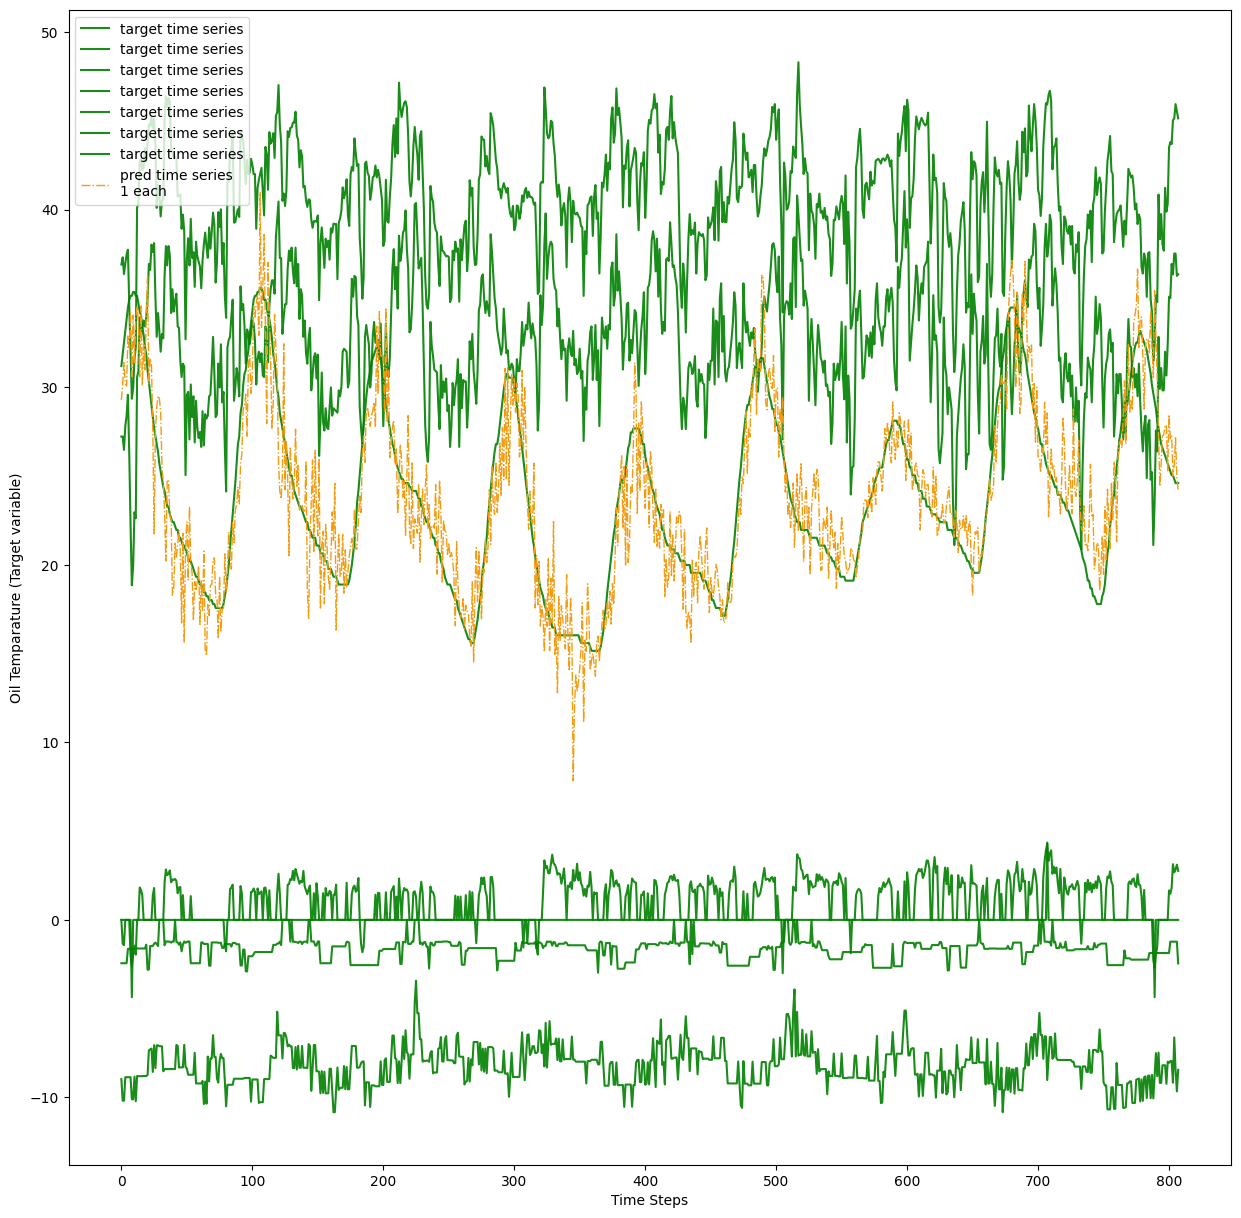

In [9]:
test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)

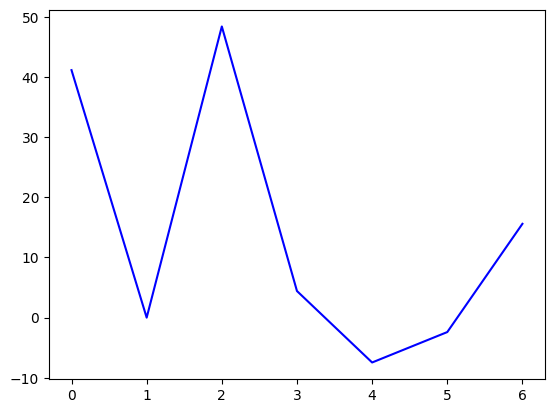

In [10]:
import matplotlib.pyplot as plt
neti = net.eval()
for i, (inputs, targets) in enumerate(test_data): 
    if i == 400: 
        break
    else: 
        output = neti(inputs)

plt.plot(output[1,:].tolist(), 'g')
plt.plot(targets[1,0,:].tolist(), 'b')

#### Dlinear

In [11]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'dlinear'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)

NameError: name 'val_df' is not defined

#### RLMP

Random seed set as 42
RMLP activated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 34.15103763961792
Current (running) training loss at iteration 10000 : 26.215125174427033
Current (running) training loss at iteration 15000 : 20.059809621302286
Current (running) training loss at iteration 20000 : 16.20290729264021
Current (running) training loss at iteration 25000 : 14.707261218910217
Current (running) training loss at iteration 30000 : 13.692369370698929

Epoch 0: 

Train metrics: -------
Running (training) loss is 12.882676473059057.
Training MAE is 0.9050180617034954.
Training MSE is 12.951467582087405.
Training MAPE is 60587659.24700862.

Val metrics: -------
Running (validation) loss is 7.078883362597772.
Validation MAE is 0.7104712083536874.
Validation MSE is 7.143642597744215.
Validation MAPE is 0.021140445516283024.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 5000 : 3.695407676792145
Current (running) training loss at i

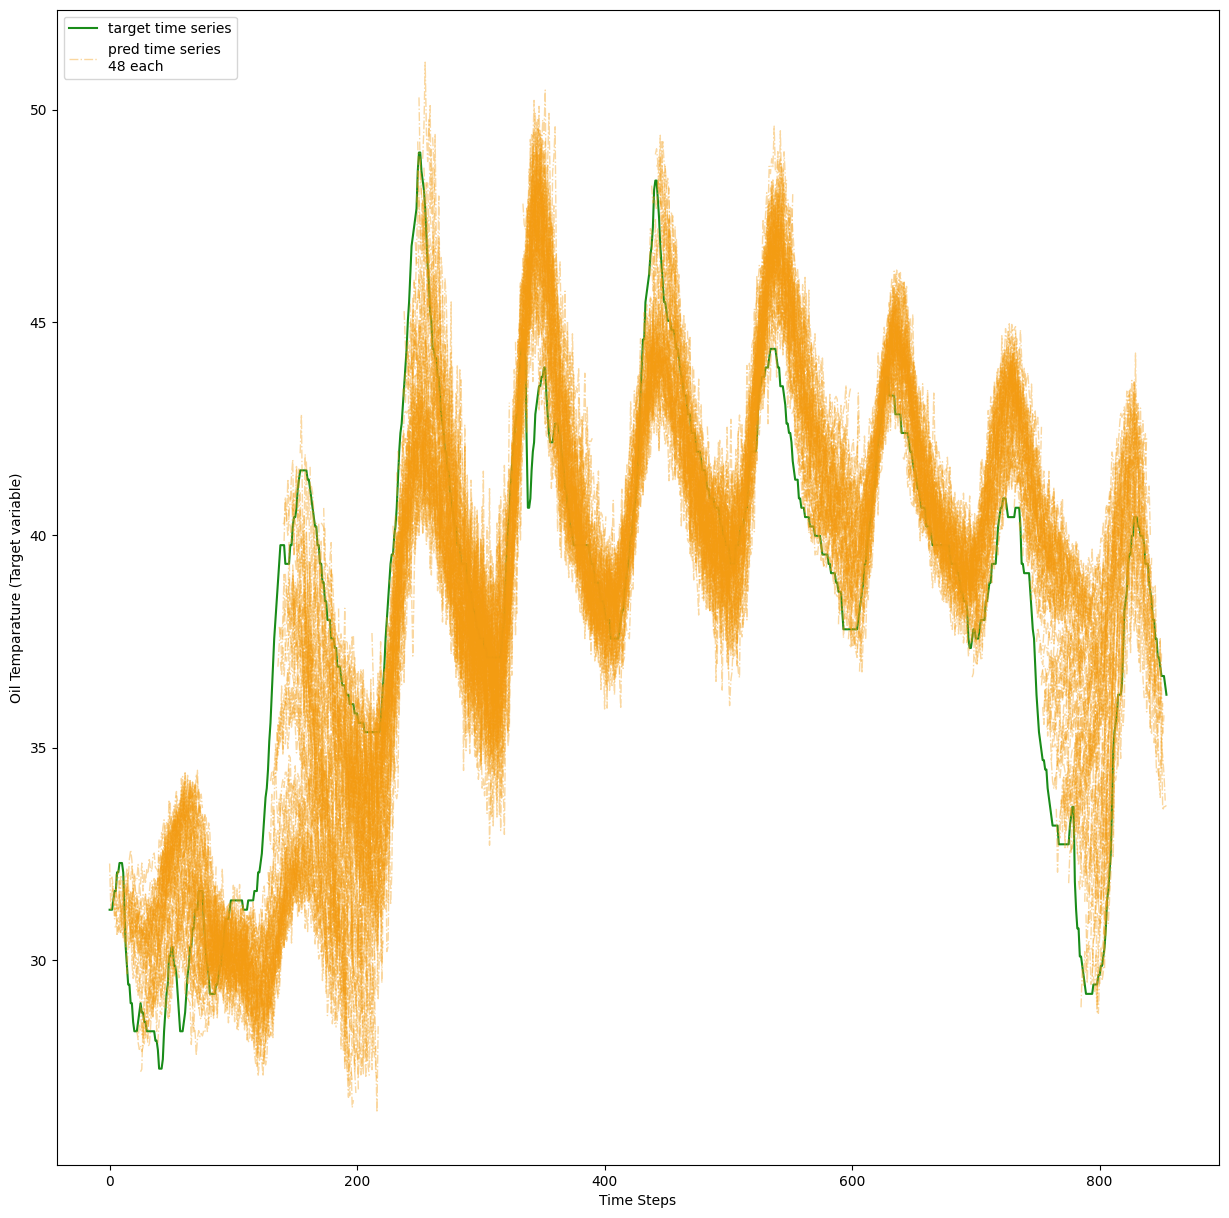

In [ ]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'rmlp'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)